# Code for figure 1 (EI of simple networks with different activation functions)

In [1]:
import os
import sys
from pathlib import Path
import pickle

sys.path.append("../")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import torch
import torch.nn as nn

from ei import topology_of, ei_of_layer

## Define colormaps

In [3]:
def greyscaleMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("binary")
    return colormap((((0.6 / size * pos) + 0.1)))

def magmaMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("magma")
    return colormap(1.0 * pos / size)

def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(0.85 * pos / size + 0.15) # avoid using the lightest blue color -- it's not visible

## Set device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using device: {device}")

Using device: cuda


## A -> B Sigmoid Plot

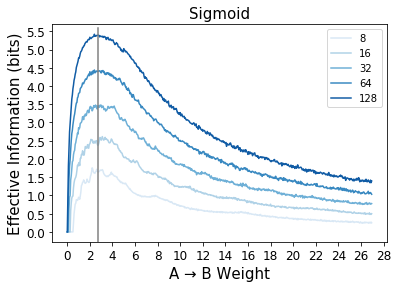

In [6]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 27, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(ei_of_layer(singleton, top, 
                               samples=10000, 
                               batch_size=1000,  
                               in_range=(0, 1),
                               in_bins=binSize,
                               out_range=(0, 1), 
                               out_bins=binSize,
                               activation=nn.Sigmoid(), 
                               device=device))
    ax.plot(ws, eis, color=color, label=str(binSize))

ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)

# Plot the vertical line indicating e
plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

ax.set_title("Sigmoid", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend()

# plt.savefig("figures/sigmoid-1d-blue", dpi=300, bbox_inches='tight')

## A, B -> C Sigmoid Plot

Text(0.5, 0, 'Effective Information (bits)')

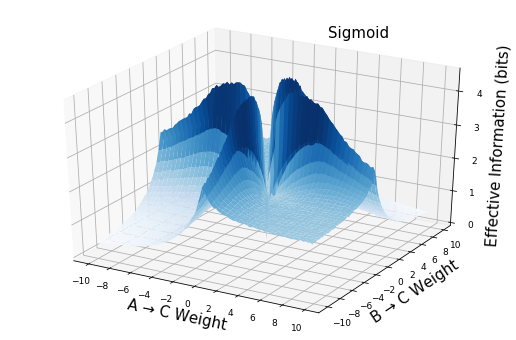

In [7]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in range(evalPoints * evalPoints):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = ei_of_layer(tiny_network, top, 
                     samples=10000, 
                     batch_size=1000, 
                     in_range=(0, 1),
                     in_bins=bins,
                     out_range=(0, 1),
                     out_bins=bins,
                     activation=nn.Sigmoid(), device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=9)

ax.set_title("Sigmoid", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('Effective Information (bits)', fontsize=15)

# plt.savefig("figures/sigmoid-2d-blue", dpi=300, bbox_inches='tight')

## A -> B Tanh

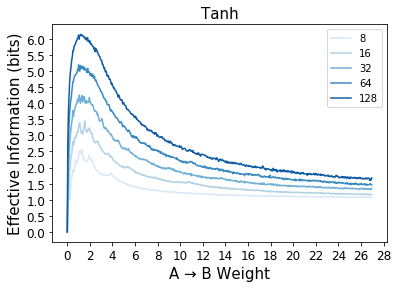

In [9]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 27, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(ei_of_layer(singleton, top, 
                               samples=10000, 
                               batch_size=1000,  
                               in_range=(-1, 1),
                               in_bins=binSize,
                               out_range=(-1, 1), 
                               out_bins=binSize,
                               activation=nn.Tanh(), 
                               device=device))
    ax.plot(ws, eis, color=color, label=str(binSize))

ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)

ax.set_title("Tanh", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend()

# plt.savefig("figures/sigmoid-1d-blue", dpi=300, bbox_inches='tight')

## A, B -> C Tanh

Text(0.5, 0, 'Effective Information (bits)')

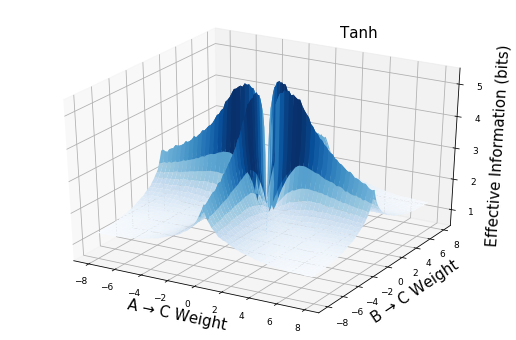

In [11]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -8.0, 8.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in range(evalPoints * evalPoints):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = ei_of_layer(tiny_network, top, 
                     samples=10000, 
                     batch_size=1000, 
                     in_range=(-1, 1),
                     in_bins=bins,
                     out_range=(-1, 1),
                     out_bins=bins,
                     activation=nn.Tanh(), 
                     device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.tick_params(axis='both',which='major',labelsize=9)

ax.set_title("Tanh", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('Effective Information (bits)', fontsize=15)

# plt.savefig("figures/tanh-2d-blue", dpi=300, bbox_inches='tight')

## A -> B ReLU: [0, 1] -> [0, 1]

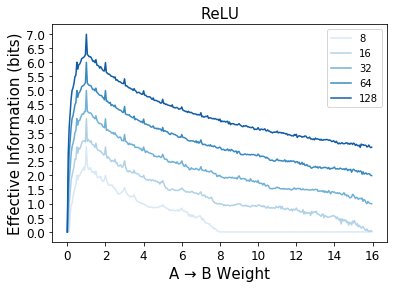

In [12]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 16, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(ei_of_layer(singleton, top, 
                               samples=5000, 
                               batch_size=1000, 
                               in_range=[0, 1],
                               in_bins=binSize,
                               out_range=[0, 1], 
                               out_bins=binSize,
                               activation=nn.ReLU(), 
                               device=device))  
    ax.plot(ws, eis, color=color, label=str(binSize))
    
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)

ax.set_title("ReLU", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend(loc="upper right")

# plt.savefig("figures/relu/relu_0_1_0_1_1d_blue", dpi=300, bbox_inches='tight')

## A, B -> C ReLU: [0, 1] -> [0, 1]

Text(0.5, 0, 'Effective Information (bits)')

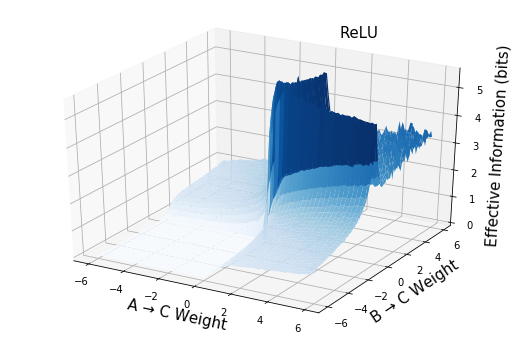

In [13]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -6, 6
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in range(evalPoints * evalPoints):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = ei_of_layer(tiny_network, top, 
                     samples=10000, 
                     batch_size=1000, 
                     in_range=(0, 1),
                     in_bins=64,
                     out_range=(0, 1), 
                     out_bins=64,
                     activation=nn.ReLU(), 
                     device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))

ax.set_title("ReLU", fontsize=15, x=0.7, y=0.965)
ax.set_xlabel('A → C Weight', fontsize=15)
ax.set_ylabel('B → C Weight', fontsize=15)
ax.set_zlabel('Effective Information (bits)', fontsize=15)

# plt.savefig("figures/relu/relu_0_1_0_1_2d-blue", dpi=300, bbox_inches='tight')